In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as sk_metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from torch.utils.data import random_split
import torch
import seaborn as sns
from tqdm import tqdm
from time import perf_counter

from nam.wrapper import NAMClassifier, MultiTaskNAMClassifier

In [2]:
random_state = 2016

In [15]:
from tensorflow import keras
# Load the CIFAR-10 dataset
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Preprocess the data
train_images = train_images / 255.0
test_images = test_images / 255.0
train_images = train_images.reshape(-1, 28*28)
test_images = test_images.reshape(-1, 28*28)
train_images.shape

(60000, 784)

In [5]:
# binary = ['sex', 'c_charge_degree']
# other = ['age', 'race', 'priors_count', 'length_of_stay']

In [118]:
def select_dataset(x, y, n1, n2):
    mask = np.where((y==n1) | (y==n2))
    return x[mask], y[mask]

train_images, train_labels = select_dataset(train_images, train_labels, 0,1)
test_images, test_labels = select_dataset(train_images, train_labels, 0,1)
# train_labels
set(test_labels)

{0, 1}

In [4]:
train_images.shape

(60000, 784)

In [6]:
# scaler = MinMaxScaler((-1, 1))
# dataset[other] = scaler.fit_transform(dataset[other])
# dataset[binary] = dataset[binary] - 1

In [20]:
# dataset

In [8]:
# data_train, data_test = train_test_split(train_images, train_labels, train_size=0.8, test_size=0.2, random_state=random_state)
# X_train, y_train = data_train[other + binary], data_train['two_year_recid']
# X_test, y_test = data_test[other + binary], data_test['two_year_recid']

## Single Task NAMs Classification

In [12]:
model = NAMClassifier(
            num_epochs=2,
            num_learners=1,
            metric='accuracy',
            early_stop_mode='max',
            monitor_loss=False,
            n_jobs=1,
            random_state=random_state
        )

from time import perf_counter
print("training")
start = perf_counter()
model.fit(train_images, train_labels)
print(perf_counter()-start)

training


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [01:28<00:00,  7.56s/it]
                                                                                                                       
100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.23it/s]
Epoch(0):                                                                                                              
                    Training Loss: 56.183 |
Epoch(0):           Validation Loss: 14.118 | ACCURACY: 0.323:   
                    Training Loss: 56.183 |
                    Validation Loss: 14.118 | ACCURACY: 0.323:  5
100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [01:35<00:00,  8.23s/it]
                                                                                                                       
100%|███████████████████████████████████████████████████████

198.05480769998394


In [13]:
pred = model.predict(test_images)
# sk_metrics.roc_auc_score(test_labels, pred)
np.mean(pred==test_labels)
# model.evaluate(test_images, test_labels)

0.993999210422424

8


(0.0, 28.0, 28.0, 0.0)

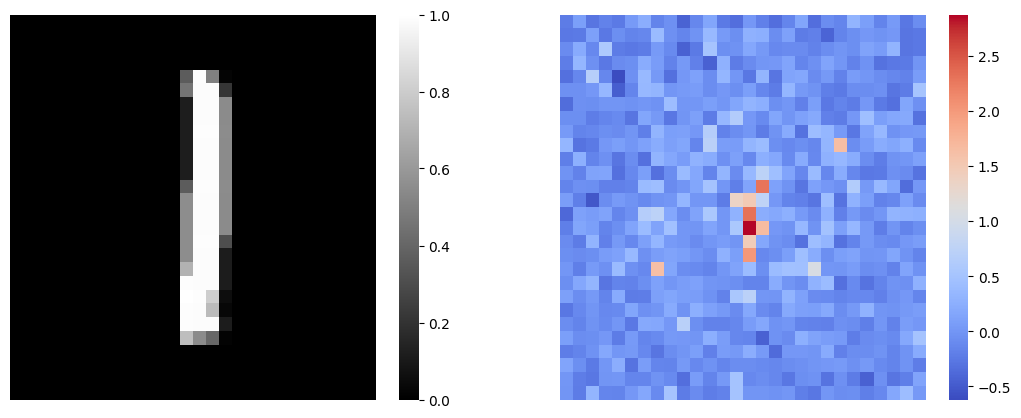

In [47]:
preds = []
idx=155

X = torch.tensor([test_images[idx]], requires_grad=False, dtype=torch.float)
for single_model in model.models:
    print(8)
    preds.append(single_model.calc_outputs(X))

# test_images[0]
image = test_images[idx].reshape(28,28)
image_importance = np.array([x.item() for x in preds[0]]).reshape(28,28)

most_important_idx = np.argmax(np.array([x.item() for x in preds[0]]))

fig,axs = plt.subplots(nrows=1,ncols=2,figsize=(13,5))


sns.heatmap(image, cmap="gray", ax=axs[0])
sns.heatmap(image_importance, cmap="coolwarm", ax=axs[1])

axs[0].axis("off")
axs[1].axis("off")

In [86]:
small_important_idx = np.argmin(np.array([x.item() for x in preds[0]]))

In [50]:
most_important_idx

434

100%|████████████████████████████████████████████████████████████████████████████████| 255/255 [00:55<00:00,  4.61it/s]


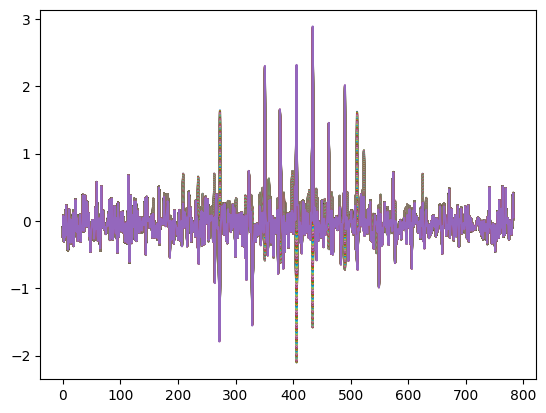

In [56]:
activations = []
test_idx = most_important_idx

test_image = test_images[idx].copy()

for i in tqdm(range(255)):
    i/=255
    test_image[:] = i
#     print(max(test_image))
    X = torch.tensor([test_image], requires_grad=False, dtype=torch.float)
    for single_model in model.models:
        model_out = single_model.calc_outputs(X)
        model_out = np.array([x.item() for x in model_out])
        activations.append(model_out)
        
for activation in activations:
    plt.plot(activation.T)

In [151]:
model.models

[NAM(
   (dropout_layer): Dropout(p=0.05, inplace=False)
   (feature_nns): ModuleList(
     (0): FeatureNN(
       (dropout): Dropout(p=0.1, inplace=False)
       (model): ModuleList(
         (0): LinReLU(in_features=1, out_features=2)
         (1): LinReLU(in_features=2, out_features=64)
         (2): LinReLU(in_features=64, out_features=32)
         (3): Linear(in_features=32, out_features=1, bias=False)
       )
     )
     (1): FeatureNN(
       (dropout): Dropout(p=0.1, inplace=False)
       (model): ModuleList(
         (0): LinReLU(in_features=1, out_features=2)
         (1): LinReLU(in_features=2, out_features=64)
         (2): LinReLU(in_features=64, out_features=32)
         (3): Linear(in_features=32, out_features=1, bias=False)
       )
     )
     (2): FeatureNN(
       (dropout): Dropout(p=0.1, inplace=False)
       (model): ModuleList(
         (0): LinReLU(in_features=1, out_features=2)
         (1): LinReLU(in_features=2, out_features=64)
         (2): LinReLU(in_feat

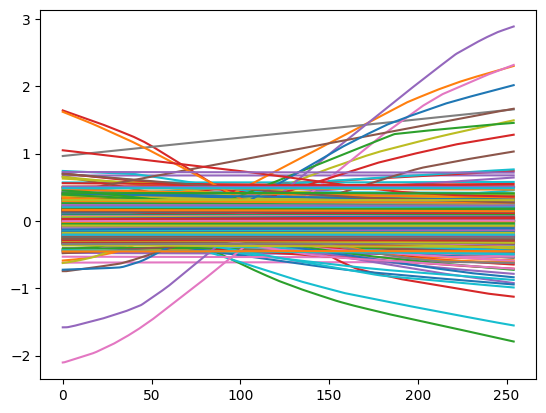

In [60]:
np.array(activations).shape
activationsT = np.array(activations).T

        
for activation in activationsT:
    plt.plot(activation)

<AxesSubplot: >

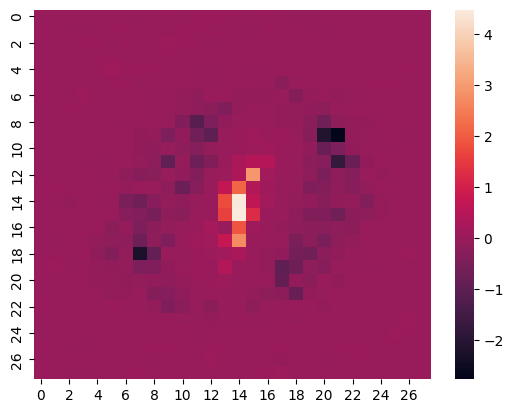

In [72]:
# std = np.std(activationsT,axis=1)
cols = activationsT[:,-1]-activationsT[:,-0]
sns.heatmap(cols.reshape(28,28))
# cols.shape

In [97]:
sorted_imp = np.argsort(cols)

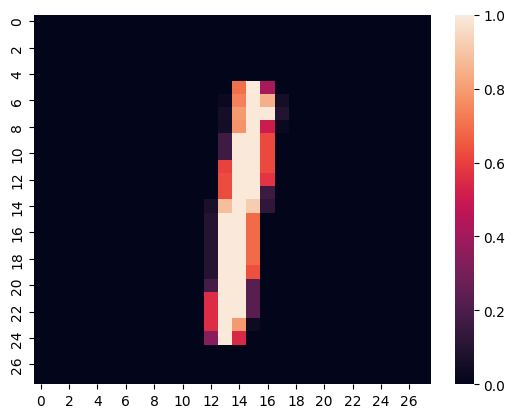

0, 1, 2, 3, 4, 1
5


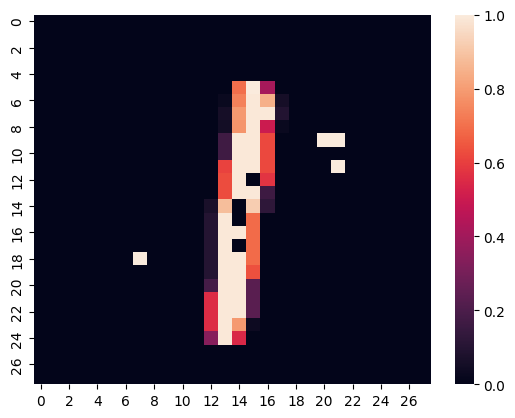

In [150]:
test_idx = 10
test_image = test_images[test_idx].copy()
sns.heatmap(test_image.reshape(28,28))
plt.show()

n_px = 0
pred = test_labels[test_idx]
while pred==test_labels[test_idx]:
    for px_idx in sorted_imp[:n_px]:
        test_image[px_idx] = 1

    for px_idx in sorted_imp[::-1][:n_px]:
        test_image[px_idx] = 0

    pred=model.predict([test_image])
    print(n_px, end=", ")
    n_px+=1


print(test_labels[test_idx])
print(n_px)
sns.heatmap(test_image.reshape(28,28))
plt.show()


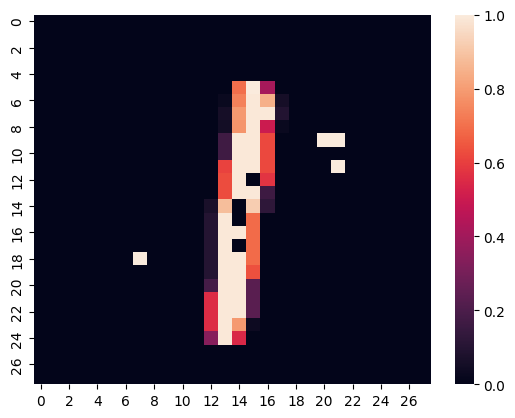

## Multitask NAMs Classification

In [32]:
def to_categorical(y, num_classes):
    """ 1-hot encodes a tensor """
    return np.eye(num_classes, dtype='uint8')[y]


lim = None
train_labels_sub = to_categorical(train_labels,10)[:lim]
test_labels_sub = to_categorical(test_labels,10)[:lim]
train_images_sub = train_images[:lim]
test_images_sub = test_images[:lim]

test_labels_sub.shape

(10000, 10)

In [194]:
import torch

model = MultiTaskNAMClassifier(
            num_learners=2,
            patience=60,
            num_epochs=100,
            num_subnets=1,
            metric='accuracy',
            monitor_loss=True,
            early_stop_mode='max',
            n_jobs=1,
            random_state=random_state,
            loss_func=torch.nn.functional.cross_entropy
        )

start = perf_counter()
print("training")
model.fit(train_images_sub, train_labels_sub)
print(perf_counter()-start)

training


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [05:34<00:00,  9.65s/it]
                                                                                                                       
100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:15<00:00,  1.68s/it]
Epoch(0):                                                                                                              
                    Training Loss: 53.849 |
Epoch(0):           Validation Loss: 1.988 | ACCURACY: 0.038:   0
                    Training Loss: 53.849 |
                    Validation Loss: 1.988 | ACCURACY: 0.038:   1


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [11:00<00:00, 20.35s/it]
                                                                                                                       
100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:31<00:00,  3.45s/it]
Epoch(1):                                                                                                              
                    Training Loss: 1.581 |
Epoch(1):           Validation Loss: 1.059 | ACCURACY: 0.077:   1%
                    Training Loss: 1.581 |
                    Validation Loss: 1.059 | ACCURACY: 0.077:   2%
  0%|                                                                                           | 0/50 [00:00<?, ?it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [12:47<00:00, 20.07s/it]
                                                                                                                       
100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:26<00:00,  2.91s/it]
Epoch(2):                                                                                                              
                    Training Loss: 1.075 |
Epoch(2):           Validation Loss: 0.771 | ACCURACY: 0.094:   2%
                    Training Loss: 1.075 |
                    Validation Loss: 0.771 | ACCURACY: 0.094:   3%
  2%|█▋                                                                                 | 1/50 [00:13<10:56, 13.40s/it]


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [11:31<00:00, 19.08s/it]
                                                                                                                       
100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:26<00:00,  2.88s/it]
Epoch(3):                                                                                                              
                    Training Loss: 0.871 |
Epoch(3):           Validation Loss: 0.650 | ACCURACY: 0.096:   3%
                    Training Loss: 0.871 |
                    Validation Loss: 0.650 | ACCURACY: 0.096:   4%
  4%|███▎                                                                               | 2/50 [00:25<10:00, 12.51s/it]


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [11:02<00:00, 18.38s/it]
                                                                                                                       
100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:28<00:00,  3.14s/it]
Epoch(4):                                                                                                              
                    Training Loss: 0.774 |
Epoch(4):           Validation Loss: 0.603 | ACCURACY: 0.096:   4%
                    Training Loss: 0.774 |
                    Validation Loss: 0.603 | ACCURACY: 0.096:   5%
  6%|████▉                                                                              | 3/50 [00:39<10:22, 13.24s/it]


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [11:40<00:00, 19.17s/it]
                                                                                                                       
100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:31<00:00,  3.48s/it]
Epoch(5):                                                                                                              
                    Training Loss: 0.710 |
Epoch(5):           Validation Loss: 0.566 | ACCURACY: 0.097:   5%
                    Training Loss: 0.710 |
                    Validation Loss: 0.566 | ACCURACY: 0.097:   6%
  8%|██████▋                                                                            | 4/50 [01:00<11:33, 15.07s/it]


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [12:52<00:00, 19.62s/it]
                                                                                                                       
100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:30<00:00,  3.33s/it]
Epoch(6):                                                                                                              
                    Training Loss: 0.672 |
Epoch(6):           Validation Loss: 0.530 | ACCURACY: 0.097:   6%
                    Training Loss: 0.672 |
                    Validation Loss: 0.530 | ACCURACY: 0.097:   7%
 10%|████████▎                                                                          | 5/50 [01:12<10:54, 14.55s/it]


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [12:24<00:00, 19.39s/it]
                                                                                                                       
100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:29<00:00,  3.27s/it]
Epoch(7):                                                                                                              
                    Training Loss: 0.643 |
Epoch(7):           Validation Loss: 0.519 | ACCURACY: 0.097:   7%
                    Training Loss: 0.643 |
                    Validation Loss: 0.519 | ACCURACY: 0.097:   8%
 12%|█████████▉                                                                         | 6/50 [01:28<10:48, 14.73s/it]


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [12:32<00:00, 18.92s/it]
                                                                                                                       
100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:28<00:00,  3.10s/it]
Epoch(8):                                                                                                              
                    Training Loss: 0.614 |
Epoch(8):           Validation Loss: 0.491 | ACCURACY: 0.097:   8%
                    Training Loss: 0.614 |
                    Validation Loss: 0.491 | ACCURACY: 0.097:   9%
 14%|███████████▌                                                                       | 7/50 [01:36<09:55, 13.86s/it]


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [12:00<00:00, 18.75s/it]
                                                                                                                       
100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:29<00:00,  3.20s/it]
Epoch(9):                                                                                                              
                    Training Loss: 0.592 |
Epoch(9):           Validation Loss: 0.477 | ACCURACY: 0.098:   9%
                    Training Loss: 0.592 |
                    Validation Loss: 0.477 | ACCURACY: 0.098:  10%
 16%|█████████████▎                                                                     | 8/50 [02:01<10:34, 15.12s/it]


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [12:37<00:00, 18.72s/it]
                                                                                                                       
100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:28<00:00,  3.16s/it]
Epoch(10):                                                                                                             
                    Training Loss: 0.581 |
Epoch(10):          Validation Loss: 0.478 | ACCURACY: 0.098:  10
                    Training Loss: 0.581 |
                    Validation Loss: 0.478 | ACCURACY: 0.098:  11
 18%|██████████████▉                                                                    | 9/50 [02:04<09:29, 13.90s/it]


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [12:04<00:00, 19.10s/it]
                                                                                                                       
100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:29<00:00,  3.22s/it]
Epoch(11):                                                                                                             
                    Training Loss: 0.569 |
Epoch(11):          Validation Loss: 0.462 | ACCURACY: 0.098:  11
                    Training Loss: 0.569 |
                    Validation Loss: 0.462 | ACCURACY: 0.098:  12
 20%|████████████████▍                                                                 | 10/50 [02:26<09:45, 14.63s/it]


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [12:32<00:00, 19.37s/it]
                                                                                                                       
100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:30<00:00,  3.32s/it]
Epoch(12):                                                                                                             
                    Training Loss: 0.548 |
Epoch(12):          Validation Loss: 0.438 | ACCURACY: 0.098:  12
                    Training Loss: 0.548 |
                    Validation Loss: 0.438 | ACCURACY: 0.098:  13
 22%|██████████████████                                                                | 11/50 [02:35<09:08, 14.06s/it]


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [12:24<00:00, 19.61s/it]
                                                                                                                       
100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:31<00:00,  3.48s/it]
Epoch(13):                                                                                                             
                    Training Loss: 0.538 |
Epoch(13):          Validation Loss: 0.436 | ACCURACY: 0.098:  13
                    Training Loss: 0.538 |
                    Validation Loss: 0.436 | ACCURACY: 0.098:  14
 24%|███████████████████▋                                                              | 12/50 [03:04<09:40, 15.28s/it]


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [13:05<00:00, 19.21s/it]
                                                                                                                       
100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:30<00:00,  3.33s/it]
Epoch(14):                                                                                                             
                    Training Loss: 0.525 |
Epoch(14):          Validation Loss: 0.426 | ACCURACY: 0.098:  14
                    Training Loss: 0.525 |
                    Validation Loss: 0.426 | ACCURACY: 0.098:  15
 26%|█████████████████████▎                                                            | 13/50 [03:09<08:53, 14.42s/it]


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [12:32<00:00, 19.21s/it]
                                                                                                                       
100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:29<00:00,  3.24s/it]
Epoch(15):                                                                                                             
                    Training Loss: 0.515 |
Epoch(15):          Validation Loss: 0.421 | ACCURACY: 0.099:  15
                    Training Loss: 0.515 |
                    Validation Loss: 0.421 | ACCURACY: 0.099:  16
 28%|██████████████████████▉                                                           | 14/50 [03:24<08:39, 14.42s/it]


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [12:50<00:00, 19.68s/it]
                                                                                                                       
100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:30<00:00,  3.29s/it]
Epoch(16):                                                                                                             
                    Training Loss: 0.507 |
Epoch(16):          Validation Loss: 0.415 | ACCURACY: 0.099:  16
                    Training Loss: 0.507 |
                    Validation Loss: 0.415 | ACCURACY: 0.099:  17
 30%|████████████████████████▌                                                         | 15/50 [03:43<08:43, 14.97s/it]


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [12:48<00:00, 19.42s/it]
                                                                                                                       
100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:31<00:00,  3.43s/it]
Epoch(17):                                                                                                             
                    Training Loss: 0.495 |
Epoch(17):          Validation Loss: 0.411 | ACCURACY: 0.099:  17
                    Training Loss: 0.495 |
                    Validation Loss: 0.411 | ACCURACY: 0.099:  18
 32%|██████████████████████████▏                                                       | 16/50 [04:12<09:00, 15.89s/it]


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [13:25<00:00, 19.62s/it]
                                                                                                                       
100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:31<00:00,  3.38s/it]
Epoch(18):                                                                                                             
                    Training Loss: 0.494 |
Epoch(18):          Validation Loss: 0.410 | ACCURACY: 0.099:  18
                    Training Loss: 0.494 |
                    Validation Loss: 0.410 | ACCURACY: 0.099:  19
 34%|███████████████████████████▉                                                      | 17/50 [04:17<08:18, 15.10s/it]


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [13:02<00:00, 19.50s/it]
                                                                                                                       
100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:32<00:00,  3.50s/it]
Epoch(19):                                                                                                             
                    Training Loss: 0.479 |
Epoch(19):          Validation Loss: 0.397 | ACCURACY: 0.099:  19
                    Training Loss: 0.479 |
                    Validation Loss: 0.397 | ACCURACY: 0.099:  20
 36%|█████████████████████████████▌                                                    | 18/50 [04:43<08:24, 15.78s/it]


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [13:26<00:00, 19.70s/it]
                                                                                                                       
100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:31<00:00,  3.35s/it]
Epoch(20):                                                                                                             
                    Training Loss: 0.474 |
Epoch(20):          Validation Loss: 0.387 | ACCURACY: 0.099:  20
                    Training Loss: 0.474 |
                    Validation Loss: 0.387 | ACCURACY: 0.099:  21
 38%|███████████████████████████████▏                                                  | 19/50 [04:54<08:00, 15.50s/it]


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [13:03<00:00, 19.36s/it]
                                                                                                                       
100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:31<00:00,  3.35s/it]
Epoch(21):                                                                                                             
                    Training Loss: 0.467 |
Epoch(21):          Validation Loss: 0.384 | ACCURACY: 0.099:  21
                    Training Loss: 0.467 |
                    Validation Loss: 0.384 | ACCURACY: 0.099:  22
 40%|████████████████████████████████▊                                                 | 20/50 [05:13<07:49, 15.67s/it]


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [13:17<00:00, 19.24s/it]
                                                                                                                       
100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:30<00:00,  3.22s/it]
Epoch(22):                                                                                                             
                    Training Loss: 0.461 |
Epoch(22):          Validation Loss: 0.388 | ACCURACY: 0.099:  22
                    Training Loss: 0.461 |
                    Validation Loss: 0.388 | ACCURACY: 0.099:  23
 42%|██████████████████████████████████▍                                               | 21/50 [05:14<07:11, 14.87s/it]


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [12:57<00:00, 19.31s/it]
                                                                                                                       
100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:31<00:00,  3.39s/it]
Epoch(23):                                                                                                             
                    Training Loss: 0.460 |
Epoch(23):          Validation Loss: 0.388 | ACCURACY: 0.099:  23
                    Training Loss: 0.460 |
                    Validation Loss: 0.388 | ACCURACY: 0.099:  24
 44%|████████████████████████████████████                                              | 22/50 [05:43<07:15, 15.57s/it]


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [13:20<00:00, 19.48s/it]
                                                                                                                       
100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:30<00:00,  3.27s/it]
Epoch(24):                                                                                                             
                    Training Loss: 0.458 |
Epoch(24):          Validation Loss: 0.380 | ACCURACY: 0.099:  24
                    Training Loss: 0.458 |
                    Validation Loss: 0.380 | ACCURACY: 0.099:  25
 46%|█████████████████████████████████████▋                                            | 23/50 [05:49<06:50, 15.21s/it]


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [13:06<00:00, 19.18s/it]
                                                                                                                       
100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:31<00:00,  3.38s/it]
Epoch(25):                                                                                                             
                    Training Loss: 0.451 |
Epoch(25):          Validation Loss: 0.380 | ACCURACY: 0.099:  25
                    Training Loss: 0.451 |
                    Validation Loss: 0.380 | ACCURACY: 0.099:  26
 48%|███████████████████████████████████████▎                                          | 24/50 [06:17<06:41, 15.45s/it]


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [13:21<00:00, 19.03s/it]
                                                                                                                       
100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:30<00:00,  3.20s/it]
Epoch(26):                                                                                                             
                    Training Loss: 0.450 |
Epoch(26):          Validation Loss: 0.378 | ACCURACY: 0.099:  26
                    Training Loss: 0.450 |
                    Validation Loss: 0.378 | ACCURACY: 0.099:  27
 50%|█████████████████████████████████████████                                         | 25/50 [06:11<06:10, 14.83s/it]


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [12:48<00:00, 19.02s/it]
                                                                                                                       
100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:31<00:00,  3.32s/it]
Epoch(27):                                                                                                             
                    Training Loss: 0.446 |
Epoch(27):          Validation Loss: 0.376 | ACCURACY: 0.099:  27
                    Training Loss: 0.446 |
                    Validation Loss: 0.376 | ACCURACY: 0.099:  28
 52%|██████████████████████████████████████████▋                                       | 26/50 [06:43<06:11, 15.47s/it]


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [13:15<00:00, 19.11s/it]
                                                                                                                       
100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:35<00:00,  3.85s/it]
Epoch(28):                                                                                                             
                    Training Loss: 0.441 |
Epoch(28):          Validation Loss: 0.379 | ACCURACY: 0.099:  28
                    Training Loss: 0.441 |
                    Validation Loss: 0.379 | ACCURACY: 0.099:  29
 54%|████████████████████████████████████████████▎                                     | 27/50 [07:13<06:06, 15.92s/it]


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [13:38<00:00, 19.20s/it]
                                                                                                                       
100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:31<00:00,  3.38s/it]
Epoch(29):                                                                                                             
                    Training Loss: 0.438 |
Epoch(29):          Validation Loss: 0.380 | ACCURACY: 0.099:  29
                    Training Loss: 0.438 |
                    Validation Loss: 0.380 | ACCURACY: 0.099:  30
 56%|█████████████████████████████████████████████▉                                    | 28/50 [07:18<05:43, 15.63s/it]


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [13:20<00:00, 19.14s/it]
                                                                                                                       
100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:31<00:00,  3.37s/it]
Epoch(30):                                                                                                             
                    Training Loss: 0.436 |
Epoch(30):          Validation Loss: 0.370 | ACCURACY: 0.099:  30
                    Training Loss: 0.436 |
                    Validation Loss: 0.370 | ACCURACY: 0.099:  31
 58%|███████████████████████████████████████████████▌                                  | 29/50 [07:24<05:20, 15.25s/it]


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [13:10<00:00, 19.33s/it]
                                                                                                                       
100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:32<00:00,  3.47s/it]
Epoch(31):                                                                                                             
                    Training Loss: 0.436 |
Epoch(31):          Validation Loss: 0.368 | ACCURACY: 0.099:  31
                    Training Loss: 0.436 |
                    Validation Loss: 0.368 | ACCURACY: 0.099:  32
 60%|█████████████████████████████████████████████████▏                                | 30/50 [07:59<05:19, 15.95s/it]


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [13:36<00:00, 19.34s/it]
                                                                                                                       
100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:32<00:00,  3.49s/it]
Epoch(32):                                                                                                             
                    Training Loss: 0.434 |
Epoch(32):          Validation Loss: 0.365 | ACCURACY: 0.099:  32
                    Training Loss: 0.434 |
                    Validation Loss: 0.365 | ACCURACY: 0.099:  33
 62%|██████████████████████████████████████████████████▊                               | 31/50 [08:12<05:03, 15.97s/it]


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [13:34<00:00, 19.31s/it]
                                                                                                                       
100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:33<00:00,  3.47s/it]
Epoch(33):                                                                                                             
                    Training Loss: 0.425 |
Epoch(33):          Validation Loss: 0.360 | ACCURACY: 0.099:  33
                    Training Loss: 0.425 |
                    Validation Loss: 0.360 | ACCURACY: 0.099:  34
 64%|████████████████████████████████████████████████████▍                             | 32/50 [08:43<04:51, 16.18s/it]


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [13:53<00:00, 19.41s/it]
                                                                                                                       
100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:33<00:00,  3.52s/it]
Epoch(34):                                                                                                             
                    Training Loss: 0.425 |
Epoch(34):          Validation Loss: 0.362 | ACCURACY: 0.099:  34
                    Training Loss: 0.425 |
                    Validation Loss: 0.362 | ACCURACY: 0.099:  35
 66%|██████████████████████████████████████████████████████                            | 33/50 [08:58<04:37, 16.33s/it]


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [13:54<00:00, 19.45s/it]
                                                                                                                       
100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:33<00:00,  3.54s/it]
Epoch(35):                                                                                                             
                    Training Loss: 0.424 |
Epoch(35):          Validation Loss: 0.362 | ACCURACY: 0.099:  35
                    Training Loss: 0.424 |
                    Validation Loss: 0.362 | ACCURACY: 0.099:  36
 68%|███████████████████████████████████████████████████████▊                          | 34/50 [09:18<04:23, 16.46s/it]


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [13:58<00:00, 19.62s/it]
                                                                                                                       
100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:33<00:00,  3.58s/it]
Epoch(36):                                                                                                             
                    Training Loss: 0.422 |
Epoch(36):          Validation Loss: 0.357 | ACCURACY: 0.099:  36
                    Training Loss: 0.422 |
                    Validation Loss: 0.357 | ACCURACY: 0.099:  37
 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [09:35<04:07, 16.51s/it]


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [14:00<00:00, 19.72s/it]
                                                                                                                       
100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:33<00:00,  3.59s/it]
Epoch(37):                                                                                                             
                    Training Loss: 0.420 |
Epoch(37):          Validation Loss: 0.355 | ACCURACY: 0.099:  37
                    Training Loss: 0.420 |
                    Validation Loss: 0.355 | ACCURACY: 0.099:  38
 72%|███████████████████████████████████████████████████████████                       | 36/50 [10:06<03:55, 16.79s/it]


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [14:16<00:00, 19.90s/it]
                                                                                                                       
100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:34<00:00,  3.66s/it]
Epoch(38):                                                                                                             
                    Training Loss: 0.418 |
Epoch(38):          Validation Loss: 0.358 | ACCURACY: 0.099:  38
                    Training Loss: 0.418 |
                    Validation Loss: 0.358 | ACCURACY: 0.099:  39
 28%|██████████████████████▉                                                           | 14/50 [03:54<10:10, 16.94s/it]
Epoch(38):                                                                                                             
                    Training Loss: 0.418 |
                   

KeyboardInterrupt: 

In [195]:
model._fitted=True

In [201]:
model.models[0].eval()
pred = torch.nn.functional.softmax(torch.tensor(model.predict_proba(test_images_sub[:100])))
# sk_metrics.roc_auc_score(test_labels, pred)
np.argmax(pred, axis=-1)
# pred

C:\Users\satch\AppData\Local\Temp\ipykernel_11456\3552509995.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = torch.nn.functional.softmax(torch.tensor(model.predict_proba(test_images_sub[:100])))


tensor([9, 6, 1, 0, 9, 9, 9, 9, 9, 9, 0, 6, 9, 9, 9, 5, 9, 7, 9, 9, 9, 6, 6, 6,
        9, 0, 9, 9, 0, 9, 9, 9, 9, 6, 9, 3, 9, 9, 6, 9, 9, 7, 9, 6, 5, 5, 9, 6,
        9, 9, 6, 9, 9, 9, 6, 0, 4, 9, 9, 9, 7, 9, 9, 3, 9, 9, 9, 9, 9, 0, 7, 0,
        3, 9, 9, 9, 9, 9, 9, 9, 9, 5, 3, 9, 9, 9, 9, 9, 6, 9, 5, 6, 9, 9, 6, 9,
        9, 9, 5, 9])

In [205]:
pred_labels = np.argmax(pred, axis=-1)
len(pred_labels)

100

In [203]:
print(set([x.item() for x in pred_labels]))

{0, 1, 3, 4, 5, 6, 7, 9}


In [206]:
test_labels_sub_labels = np.argmax(test_labels_sub[:100], axis=-1)

np.mean(pred_labels.detach().numpy()==test_labels_sub_labels[:100])

0.34

(array([5923., 6742., 5958., 6131., 5842., 5421., 5918., 6265., 5851.,
        5949.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

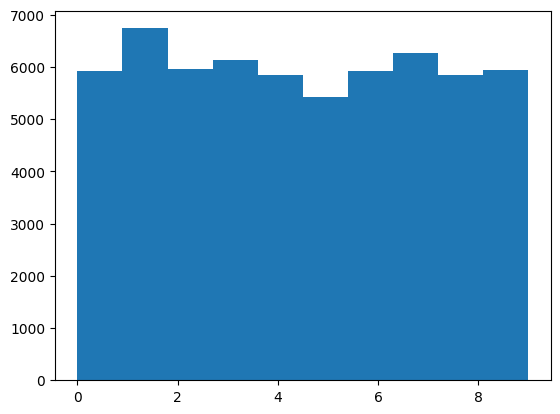

In [156]:
plt.hist(np.argmax(train_labels_sub, axis=1))

7


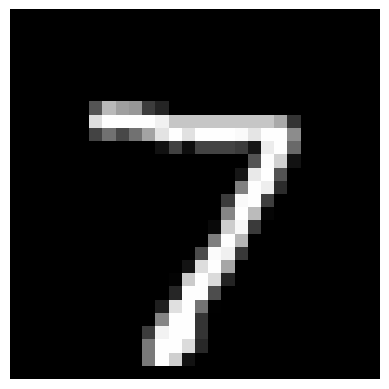

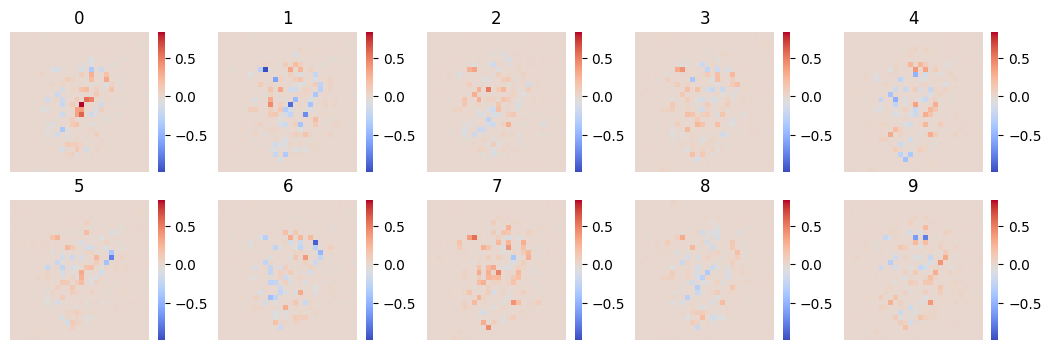

<BarContainer object of 10 artists>

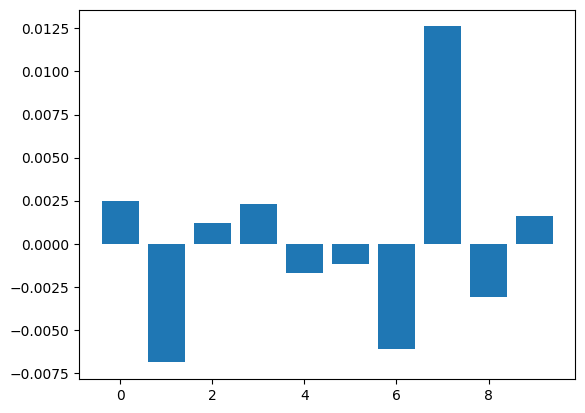

In [255]:
preds = []
idx=0
# model.dropout=0
# model.feature_dropout=0
# model.dropout_layer = torch.nn.Dropout(p=0)

# np.random.seed()
# torch.random.seed()

# for i in range(784):
#     model.models[0].feature_nns[i].dropout = torch.nn.Dropout(p=0)

model.models[0].eval()

X = torch.tensor([test_images[idx]], requires_grad=False, dtype=torch.float)
# for single_model in model.models:
#     preds.append(single_model.calc_outputs(X))
preds = model.models[0].calc_outputs(X)
label_pred = model.predict_proba(X)
print(np.argmax(label_pred))

preds = [x.squeeze().detach().numpy() for x in preds]

preds = np.array(preds)
preds = preds.T

image = test_images[idx].reshape(28,28)
plt.imshow(image, cmap="gray")
plt.axis("off")

fig,axs = plt.subplots(nrows=2,ncols=5,figsize=(13,4))
axs = axs.flatten()

vmax = np.max(preds)
vmin = np.min(preds)
means = []
for i in range(10):
    image_importance = preds[i].reshape(28,28) 
    means.append(np.mean(image_importance))
    most_important_idx = np.argmax(np.array([x.item() for x in preds[0]]))
    #image_importance[abs(image_importance) < 0.08] = 0

#     sns.heatmap(image, cmap="gray", ax=axs[0])
    sns.heatmap(image_importance, cmap="coolwarm", ax=axs[i], vmin=vmin, vmax=vmax)

#     axs[0].axis("off")
    axs[i].axis("off")
    axs[i].set_title(i)
    
plt.show()
plt.bar(np.arange(0,10), means)

In [219]:
# model.models[0].save("epoch38_single_nam.h5")
# print(model.models[0]._bias.detach().numpy().squeeze())

from nam.models.saver import Checkpointer

checkpointer = Checkpointer(log_dir="output_long/0") # only one model
checkpointer.save(model.models[0], "best")

IndexError: list index out of range

### Loading saved checkpoint

In [223]:
model = MultiTaskNAMClassifier(
            num_learners=1,
            patience=60,
            num_epochs=100,
            num_subnets=1,
            metric='accuracy',
            monitor_loss=True,
            early_stop_mode='max',
            n_jobs=1,
            random_state=random_state,
            loss_func=torch.nn.functional.cross_entropy
        )

model.load_checkpoints("output_long")

model.models[0].eval()
pred = torch.nn.functional.softmax(torch.tensor(model.predict_proba(test_images_sub[:100])))
test_labels_sub_labels = np.argmax(test_labels_sub[:100], axis=-1)
np.mean(pred_labels.detach().numpy()==test_labels_sub_labels[:100])

C:\Users\satch\AppData\Local\Temp\ipykernel_11456\3249629709.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = torch.nn.functional.softmax(torch.tensor(model.predict_proba(test_images_sub[:100])))


0.34

In [158]:
preds.shape

(10, 784)

In [159]:
pred

tensor([[0.0838, 0.1084, 0.0983,  ..., 0.1103, 0.1034, 0.1024],
        [0.0885, 0.0853, 0.1461,  ..., 0.0767, 0.1007, 0.0782],
        [0.0838, 0.1225, 0.0994,  ..., 0.1048, 0.1042, 0.0966],
        ...,
        [0.0741, 0.1042, 0.0873,  ..., 0.1083, 0.1217, 0.0986],
        [0.0848, 0.1038, 0.1125,  ..., 0.0916, 0.1150, 0.0881],
        [0.0965, 0.0972, 0.1164,  ..., 0.0943, 0.0990, 0.0907]],
       dtype=torch.float64)

In [230]:
activations = []
test_idx = most_important_idx

test_image = np.zeros(test_images[idx].shape)

for i in tqdm(range(255)):
    i/=255
    test_image[:] = i
#     print(max(test_image))
    X = torch.tensor([test_image], requires_grad=False, dtype=torch.float)
    for single_model in model.models:
        model_out = single_model.calc_outputs(X)
        model_out = np.array([x.detach().numpy().squeeze() for x in model_out])
        activations.append(model_out)

100%|████████████████████████████████████████████████████████████████████████████████| 255/255 [01:16<00:00,  3.35it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:09<00:00,  1.01it/s]


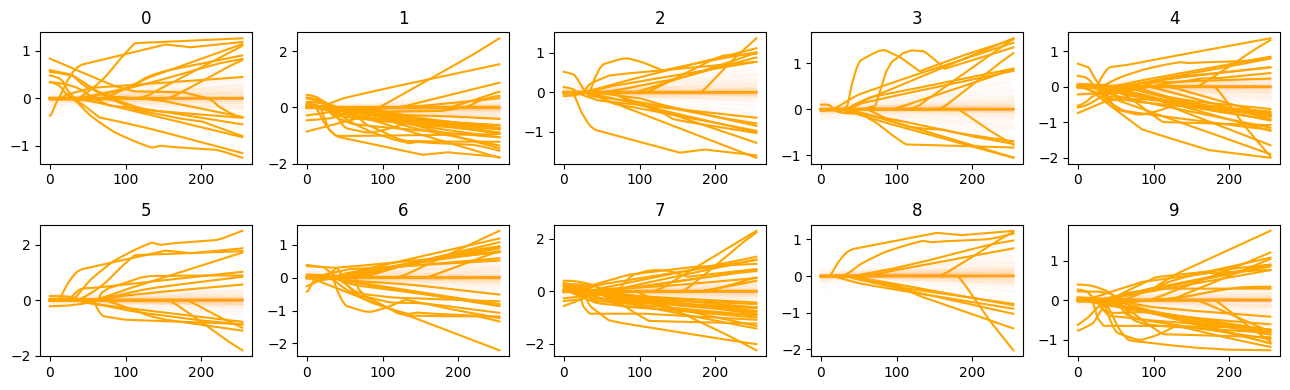

In [259]:
activations = np.array(activations)
activations_reshaped = activations.transpose((2,0,1))

fig,axs = plt.subplots(nrows=2,ncols=5,figsize=(13,4))
axs = axs.flatten()

for i in tqdm(range(10)):
    axs[i].set_title(i)
    for act in activations_reshaped[i].T:
#         axs[i].plot(act)
        if abs(act[-1]-act[0])<0.75:
            axs[i].plot(act, alpha=0.01, color="orange")
        else:
            axs[i].plot(act, color="orange")
        

plt.tight_layout()
# activations_reshaped[0]


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.23it/s]


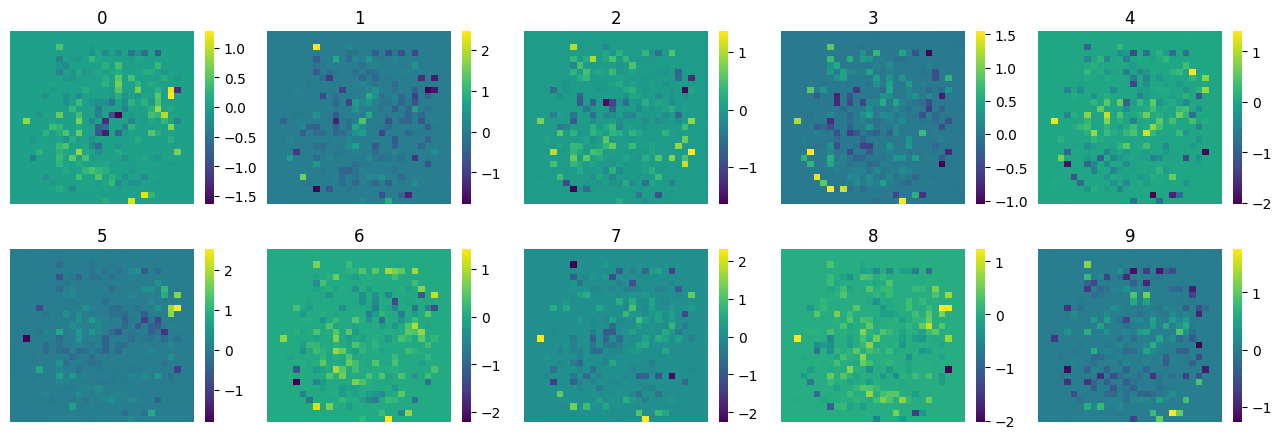

In [263]:
fig,axs = plt.subplots(nrows=2,ncols=5,figsize=(13,4.5))
axs = axs.flatten()

for i in tqdm(range(10)):
    axs[i].set_title(i)
    actT = activations_reshaped[i].T
#     cols = np.std(actT, axis=1)
#     cols = np.max(actT, axis=1)-np.min(actT[:], axis=1)
    cols = actT[:,-1]-actT[:,0]
    sns.heatmap(cols.reshape(28,28), ax=axs[i], cmap="viridis")
    axs[i].axis("off")
plt.tight_layout()

